# Getting training data for translation

> "Build our training data using the annotations we brokedown and the genome sequences we've stored."

We need to know which sequences of DNA create which sequences of protein.

A gene can be made up of multiple coding and non-coding sequences.

Our training task is translation from genomic DNA (skipping transcription) to protein sequences.

This means that some sections of genomic DNA will produce no protein sequences and others will, even within the same gene.

I also have to plan around the fact that I have limited computing resources, and I may not be able to train a model with sufficient window size to encapsulate an entire gene.

With this in mind, we need to be able to flexibly get training data where we can slice genomic dna at any location and get the protein sequences that slice is responsible for creating.

I.E.

Gene X has a sequence of 1,000 base pairs.

There is a coding sequence from bases 0 to 100 and from 200 to 1000.

What does the training data look like if we sliced gene X from;

1. positions 0 to 100?
2. positions 0 to 150?
3. positions 150 to 300?
4. positions 500 to 1,000?

In [ ]:
#| default_exp features.annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from Bio import SeqIO, Entrez
from Bio.SeqFeature import SeqFeature, FeatureLocation
import re
import json
from multiprocessing import Pool
import os
import sys

pd.options.mode.chained_assignment = None

/home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages
  warnings.warn(


In [ ]:
#| hide
from io import StringIO
from yaml import safe_load

tqdm.pandas(ncols=80, leave=False)

with open("../config.yml") as f:
    config = safe_load(f)

In [ ]:
#| hide
data_path = Path(config.get("data_path"))
annotations_path = data_path / "annotations"
genome_path = data_path / "genome"
sequences_path = data_path / "entrez_genes_sequences"
protein_path = data_path / "protein"
if not sequences_path.exists():
    sequences_path.mkdir()

Entrez.email = config.get("email")
Entrez.api_key = config.get("nih_api_key")

## Get gene annotations

In [ ]:
#| hide
annotation_id = "NC_000014.9"
test_annotation_file = annotations_path / f"{annotation_id}.csv"

In [ ]:
#| hide
test_annotations = pd.read_csv(test_annotation_file)
test_annotations.sample(5)

,seqid,source,type,start,end,score,strand,phase,attributes
23436,NC_000014.9,BestRefSeq,exon,35312881,35313059,NaN,+,NaN,ID=exon-NR_182667.1-12;Parent=rna-NR_182667.1;...
36655,NC_000014.9,Gnomon,exon,50735516,50735617,NaN,-,NaN,ID=exon-XM_047431440.1-27;Parent=rna-XM_047431...
65338,NC_000014.9,BestRefSeq,exon,65629492,65629606,NaN,+,NaN,ID=exon-NM_001371536.1-7;Parent=rna-NM_0013715...
53006,NC_000014.9,Gnomon,exon,60027884,60028101,NaN,+,NaN,ID=exon-XM_024449564.2-28;Parent=rna-XM_024449...
104928,NC_000014.9,Gnomon,exon,93528558,93528646,NaN,+,NaN,ID=exon-XM_011537018.3-9;Parent=rna-XM_0115370...


In [ ]:
#| hide
test_annotations.iloc[0, :]

seqid                                               NC_000014.9
source                                                   RefSeq
type                                                     region
start                                                         1
end                                                   107043718
score                                                       NaN
strand                                                        +
phase                                                       NaN
attributes    ID=NC_000014.9:1..107043718;Dbxref=taxon:9606;...
Name: 0, dtype: object

In [ ]:
#| export
def parse_annotation_value(annotation_value: str):
    """
    Handle multiple values in the attribute.
    Return value if list or dict if key-value pair
    """
    annotation_split = annotation_value.split(":")
    if len(annotation_split) == 1:
        return annotation_value
    return {annotation_split[0]: annotation_split[1]}


def parse_annotation_attribute_values(attribute_values: str) -> object:
    """
    Detect if an attribute value is really a dict or list.
    """
    value_list = attribute_values.split(",")
    if len(value_list) == 1:
        return attribute_values
    parsed_values = [parse_annotation_value(value) for value in value_list]
    # Dict within a list
    if ":" in value_list[0]:
        attribute_values = {}
        for parsed_value in parsed_values:
            if isinstance(parsed_value, dict):
                attribute_values.update(parsed_value)
    # Just a list within a list
    else:
        attribute_values = parsed_values
    return attribute_values


def parse_entrez_gff3_annotation_attributes(attributes_str: str):
    """
    Convert attribute string to parsed attribute dict.
    
    Split on ';' to get attributes.
    Values can also be nested as a dict or list.
    """
    attr_list = attributes_str.split(";")
    attr_dict = {
        k: parse_annotation_attribute_values(v) for k, v in [attr.split("=") for attr in attr_list]
    }
    return attr_dict

In [ ]:
#| hide
test_annotations.loc[:, 'attributes_dict'] = test_annotations.attributes.apply(parse_entrez_gff3_annotation_attributes)

In [ ]:
#| hide
test_row = 0
display(test_annotations.iloc[test_row, :-2])
test_annotations.iloc[test_row, -1]

seqid     NC_000014.9
source         RefSeq
type           region
start               1
end         107043718
score             NaN
strand              +
phase             NaN
Name: 0, dtype: object

{'ID': 'NC_000014.9:1..107043718',
 'Dbxref': 'taxon:9606',
 'Name': '14',
 'chromosome': '14',
 'gbkey': 'Src',
 'genome': 'chromosome',
 'mol_type': 'genomic DNA'}

### Summary:

For each annotations document:
- Read it as a csv via pandas
- Parse the annotations column
- Return dataframe with annotations_dict column

## Converting annotations to SeqRecords for training.

Genes are made up of multiple elements.

- Genes
    - Entire DNA sequence encoding the information for a protein.
- Introns
    - Sections of DNA ignored during transcription.
- Exons
    - Sections of DNA included in the transcription product.
- UTRs (Untranslated Retions)
    - Sections of mRNA ignored during translation.
- CDS (Coding Sequence)
    - Sections of mRNA that are translated to protein.

    
The annotations we have include all this information. Lets extract a SeqRecord object using the annotations that has all this information.

Transformation plan:

1. Filter gff features to those belonging to a gene
2. Create the initial SeqRecord from the feature with `featuretype='gene'`
3. Collect all features with geneID belonging to SeqRecord from [2] (for each)
4. Annotate SeqRecord with features
5. Write SeqRecord with features

In [ ]:
#| export
def get_gene_id_from_attribute_dict(attribute_dict: dict):
    dbxref = attribute_dict.get("Dbxref", {})
    if isinstance(dbxref, str):
        return None
    elif isinstance(dbxref, dict):
        return dbxref.get("GeneID", None)
    else:
        return None

In [ ]:
#| hide
test_annotations.loc[:, 'annotation_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("ID"))
test_annotations.loc[:, 'gene_id'] = test_annotations.attributes_dict.apply(get_gene_id_from_attribute_dict)
test_annotations.loc[:, 'protein_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("protein_id"))
test_annotations.loc[:, 'parent_annotation_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("Parent"))

test_annotations.head()

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id
0,NC_000014.9,RefSeq,region,1,107043718,NaN,+,NaN,ID=NC_000014.9:1..107043718;Dbxref=taxon:9606;...,"{'ID': 'NC_000014.9:1..107043718', 'Dbxref': '...",NC_000014.9:1..107043718,None,None,None
1,NC_000014.9,RefSeq,centromere,16000001,18173523,NaN,+,NaN,ID=id-NC_000014.9:16000001..18173523;Note=Line...,"{'ID': 'id-NC_000014.9:16000001..18173523', 'N...",id-NC_000014.9:16000001..18173523,None,None,None
2,NC_000014.9,Curated Genomic,pseudogene,16024658,16025641,NaN,+,NaN,"ID=gene-DUX4L48;Dbxref=GeneID:107105251,HGNC:H...","{'ID': 'gene-DUX4L48', 'Dbxref': {'GeneID': '1...",gene-DUX4L48,107105251,None,None
3,NC_000014.9,Curated Genomic,pseudogene,16028061,16028716,NaN,+,NaN,"ID=gene-PCMTD1P6;Dbxref=GeneID:107105255,HGNC:...","{'ID': 'gene-PCMTD1P6', 'Dbxref': {'GeneID': '...",gene-PCMTD1P6,107105255,None,None
4,NC_000014.9,Curated Genomic,exon,16028061,16028716,NaN,+,NaN,ID=id-PCMTD1P6;Parent=gene-PCMTD1P6;Dbxref=Gen...,"{'ID': 'id-PCMTD1P6', 'Parent': 'gene-PCMTD1P6...",id-PCMTD1P6,107105255,None,gene-PCMTD1P6


In [ ]:
#| hide
# How long are these coding sequences anyway?
test_annotations_cds = test_annotations[test_annotations.type == "CDS"]
(test_annotations_cds.end - test_annotations_cds.start).describe()

count    52792.000000
mean       162.975924
std        259.262548
min          0.000000
25%         82.000000
50%        120.000000
75%        170.000000
max      16736.000000
dtype: float64

In [ ]:
#| hide
gene_to_protein_map = test_annotations[['gene_id', 'protein_id']].dropna().drop_duplicates().reset_index(drop=True)
gene_to_protein_map.sample(5)

,gene_id,protein_id
377,10278,NP_001372536.1
3869,113146,XP_024305231.1
37,7011,XP_011535412.1
118,57447,NP_963833.1
3734,3831,NP_001381773.1


<Axes: xlabel='protein_id'>

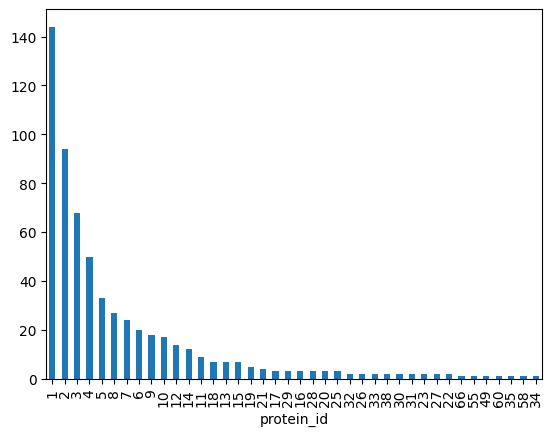

In [ ]:
#| hide
# The number of gene ids with **x** protein_ids. 
# I.E. x = 1 and y = ~140 means there are 140 gene ids with one protein.
gene_to_protein_map.groupby("gene_id").protein_id.nunique().value_counts().plot(kind='bar')

In [ ]:
#| hide
genes_that_encode_protein = gene_to_protein_map.gene_id.unique().tolist()

In [ ]:
#| hide
test_gene_annotations_df = test_annotations[test_annotations.gene_id.isin(genes_that_encode_protein)]
test_gene_annotations_df.shape[0]

118010

In [ ]:
#| hide
test_gene_reference_sequence_id = test_gene_annotations_df.seqid.values[0]
test_reference_sequence_path = genome_path / f"{test_gene_reference_sequence_id}.fasta"
test_gene_reference_sequence = next(SeqIO.parse(test_reference_sequence_path.resolve(), "fasta"))

In [ ]:
#| export
def get_sequence_from_file(
    start: int, end: int, strand: str = "+", 
    sequence_record: SeqIO.SeqRecord = None, fasta_path: Path = None) -> SeqIO.SeqRecord:
    """
    The Fasta file at fasta_path is a single record.
    If strand is positive, index and return sequence.
    If strand is negative, reverse the index and return.
    """
    if sequence_record is None and fasta_path is None:
        raise ValueError("Both sequence_record and fasta_path cannot be None")
    if sequence_record is None:
        sequence_record = next(SeqIO.parse(fasta_path.resolve(), "fasta"))
    selected_sequence = sequence_record[start - 1: end]
    if strand == "-":
        selected_sequence = selected_sequence.reverse_complement()
    return selected_sequence.upper()

Plan is;

1. Group on gene_id
2. Build initial "source" gene sequence record
3. Identify "groups" of feature rows by their parent-child references
4. For each group of features, create an annotated sequence

In [ ]:
#| hide
test_gene_id_groups = test_gene_annotations_df.groupby("gene_id")
# test_gene_id_group_id = list(test_gene_id_groups.groups.keys())[0]
test_gene_id_group_id = "441669"
# test_gene_id_group_id = "100128927"
test_gene_id_group = test_gene_id_groups.get_group(test_gene_id_group_id)
test_gene_id_group.head()

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id
298,NC_000014.9,BestRefSeq%2CGnomon,gene,19743571,19752334,NaN,+,NaN,"ID=gene-OR4Q3;Dbxref=GeneID:441669,HGNC:HGNC:1...","{'ID': 'gene-OR4Q3', 'Dbxref': {'GeneID': '441...",gene-OR4Q3,441669,None,None
299,NC_000014.9,BestRefSeq,mRNA,19743571,19749469,NaN,+,NaN,ID=rna-NM_001405963.1;Parent=gene-OR4Q3;Dbxref...,"{'ID': 'rna-NM_001405963.1', 'Parent': 'gene-O...",rna-NM_001405963.1,441669,None,gene-OR4Q3
300,NC_000014.9,BestRefSeq,exon,19743571,19743671,NaN,+,NaN,ID=exon-NM_001405963.1-1;Parent=rna-NM_0014059...,"{'ID': 'exon-NM_001405963.1-1', 'Parent': 'rna...",exon-NM_001405963.1-1,441669,None,rna-NM_001405963.1
301,NC_000014.9,BestRefSeq,exon,19747406,19749469,NaN,+,NaN,ID=exon-NM_001405963.1-2;Parent=rna-NM_0014059...,"{'ID': 'exon-NM_001405963.1-2', 'Parent': 'rna...",exon-NM_001405963.1-2,441669,None,rna-NM_001405963.1
302,NC_000014.9,BestRefSeq,CDS,19743670,19743671,NaN,+,0.0,ID=cds-NP_001392892.1;Parent=rna-NM_001405963....,"{'ID': 'cds-NP_001392892.1', 'Parent': 'rna-NM...",cds-NP_001392892.1,441669,NP_001392892.1,rna-NM_001405963.1


In [ ]:
#| export
def get_gene_row_from_annotation_group(annotations: pd.DataFrame) -> pd.Series:
    gene_rows = annotations[annotations.type == "gene"]
    if gene_rows.shape[0] == 0:
        raise ValueError("There are no 'gene' rows")
    elif gene_rows.shape[0] > 1:
        display(gene_rows)
        raise ValueError("There are more than 1 'gene' rows")
    gene_row = gene_rows.iloc[0, :]
    return gene_row


def get_row_sequence(
    sequence_row: pd.Series, 
    reference_sequence: SeqIO.SeqRecord
) -> SeqIO.SeqRecord:
    """
    """
    sequence_record = get_sequence_from_file(
        int(sequence_row.start), int(sequence_row.end), sequence_row.strand, 
        reference_sequence
    )
    sequence_record.id = sequence_row.annotation_id
    sequence_record.annotations = sequence_row.attributes_dict
    return sequence_record

In [ ]:
#| hide
test_gene_id_group_gene_row = get_gene_row_from_annotation_group(test_gene_id_group)

In [ ]:
#| hide
test_gene_id_group_gene_sequence = get_row_sequence(
    test_gene_id_group_gene_row,
    test_gene_reference_sequence
)

In [ ]:
#| hide
test_gene_id_group_gene_sequence

SeqRecord(seq=Seq('GCCCATTTTGCTGGCCTGAGGCTGAAGAGAGGGTTGATAGGATGAATGGCAGGA...CAA'), id='gene-OR4Q3', name='NC_000014.9', description='NC_000014.9 Homo sapiens chromosome 14, GRCh38.p14 Primary Assembly', dbxrefs=[])

In [ ]:
#| hide
# Validate on a positive strand gene
validation_positive_strand_gene_row = test_gene_annotations_df[
    (test_gene_annotations_df.strand == "+") &
    (test_gene_annotations_df.type == "gene")
].iloc[0, :]
validation_positive_strand_gene_row

seqid                                                         NC_000014.9
source                                                         BestRefSeq
type                                                                 gene
start                                                            18601117
end                                                              18602097
score                                                                 NaN
strand                                                                  +
phase                                                                 NaN
attributes              ID=gene-OR11H12;Dbxref=GeneID:440153,HGNC:HGNC...
attributes_dict         {'ID': 'gene-OR11H12', 'Dbxref': {'GeneID': '4...
annotation_id                                                gene-OR11H12
gene_id                                                            440153
protein_id                                                           None
parent_annotation_id                  

In [ ]:
#| hide
# Get the validation sequence
validation_positive_strand_gene_sequence = get_row_sequence(
    validation_positive_strand_gene_row,
    test_gene_reference_sequence
)

Okay, we can get genes, lets get the base annotation and start annotating it with more info.

In [ ]:
#| export
def annotate_token(token: str, token_type: str, token_position: int = None):
    if token_type == "nucleotide":
        return f"[N]{token}"
    elif token_type == "aminoacid":
        if token_position is None:
            raise ValueError("token_position cannot be None if token_type is 'aminoacid'")
        return f"f[A]{token}-{token_position}"
    else:
        raise ValueError(f"Unknown token_type passed: {token_type}")
        
        
def annotate_sequence(sequence: list[str], token_type: str):
    sequence_annotation = list(
        map(
            lambda token: annotate_token(
                token, token_type
            ), 
            sequence
        )
    )
    return sequence_annotation

In [ ]:
#| hide
test_gene_id_gene_annotation = annotate_sequence(
    list(test_gene_id_group_gene_sequence.seq),
    "nucleotide"
)
test_gene_id_gene_annotation[:5]

['[N]G', '[N]C', '[N]C', '[N]C', '[N]A']

In [ ]:
#| export
def validate_gene_annotation(gene_row: pd.Series, annotation: list[str]):
    gene_length = gene_row.end - gene_row.start + 1
    assert len(annotation) == gene_length

In [ ]:
#| hide
validate_gene_annotation(test_gene_id_group_gene_row, test_gene_id_gene_annotation)

Now lets annotate the mRNA sequences.

This is complicated. You can't validate your mRNA against the source sequence in Entrez until you handle splicing.

To do so we need to utilize the rows with their type == `mRNA` and `exon`.

We also need to keep in mind how this maps back to our input-output training data.

We need to annotate every DNA nucleotide with what it contributes to translation.

This means that intronic and exonic mRNA needs to be labeled.

There are various things that happen to mRNA as well that make it impossible to map directly from the reference genome to mRNA. The best we can do with that in mind is to identify what we need to annotate our data.

Lets get intronic and exonic index values in the annotation sequence.

In [ ]:
#| export
def get_mrna_exon_idx(gene_row: pd.Series, mrna_row: pd.Series, exon_rows: pd.DataFrame) -> set[int]:
    exon_idx = set()
    # For each exon, mark sequence as exonic
    for idx, ex_row in exon_rows.iterrows():
        # Normalize the index values to the mrna sequence zero-index
        rel_start = ex_row.start - gene_row.start
        rel_end = ex_row.end - gene_row.start + 1
        exon_idx.update(list(range(rel_start, rel_end)))
    # Get intron idx
    intron_idx = [i for i in range(mrna_row.start, mrna_row.end + 1) if i not in exon_idx]
    return exon_idx


def get_mrna_annotations(
    gene_row: pd.Series,
    annotations: pd.DataFrame, 
    reference_sequence: SeqIO.SeqRecord
) -> pd.DataFrame:
    mrna_rows = annotations[annotations.type == "mRNA"]
    if mrna_rows.shape[0] == 0:
        return
    # Get the base sequences
    mrna_rows.loc[:, 'record'] = mrna_rows.apply(
        lambda row: get_sequence_from_file(
            row.start, row.end, row.strand, 
            reference_sequence
        ), 
        axis=1
    )
    exon_rows = annotations[annotations.type == "exon"]
    exon_rows.loc[:, 'record'] = exon_rows.apply(
        lambda row: get_sequence_from_file(
            row.start, row.end, row.strand, 
            reference_sequence
        ), 
        axis=1
    )
    # Now, assign exons to their mRNA sequences
    mrna_rows.loc[:, 'exon_idx'] = mrna_rows.apply(
        lambda row: get_mrna_exon_idx(gene_row, row, exon_rows[exon_rows.parent_annotation_id == row.annotation_id]),
        axis=1
    )
    return mrna_rows

In [ ]:
#| hide
test_gene_id_mrna_sequences = get_mrna_annotations(test_gene_id_group_gene_row, test_gene_id_group, test_gene_reference_sequence)
test_gene_id_mrna_sequences

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id,record,exon_idx
299,NC_000014.9,BestRefSeq,mRNA,19743571,19749469,NaN,+,NaN,ID=rna-NM_001405963.1;Parent=gene-OR4Q3;Dbxref...,"{'ID': 'rna-NM_001405963.1', 'Parent': 'gene-O...",rna-NM_001405963.1,441669,None,gene-OR4Q3,"(G, C, C, C, A, T, T, T, T, G, C, T, G, G, C, ...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
304,NC_000014.9,Gnomon,mRNA,19744740,19752334,NaN,+,NaN,ID=rna-XM_024449618.1;Parent=gene-OR4Q3;Dbxref...,"{'ID': 'rna-XM_024449618.1', 'Parent': 'gene-O...",rna-XM_024449618.1,441669,None,gene-OR4Q3,"(A, T, G, A, A, G, C, T, G, G, T, G, T, T, T, ...","{4096, 4097, 4098, 4099, 4100, 4101, 4102, 410..."
313,NC_000014.9,BestRefSeq,mRNA,19747428,19748369,NaN,+,NaN,ID=rna-NM_172194.1;Parent=gene-OR4Q3;Dbxref=Ge...,"{'ID': 'rna-NM_172194.1', 'Parent': 'gene-OR4Q...",rna-NM_172194.1,441669,None,gene-OR4Q3,"(A, T, G, A, A, A, A, A, A, G, A, A, C, A, A, ...","{4096, 4097, 4098, 4099, 4100, 4101, 4102, 410..."


In [ ]:
#| export
def get_mrna_annotation(gene_row: pd.Series, base_annotation: list[str], mrna_row: pd.Series) -> list[str]:
    mrna_start_norm = mrna_row.start - gene_row.start
    mrna_end_norm = mrna_row.end + 1 - gene_row.start
    mrna_annotation = base_annotation.copy()
    # print(mrna_start_norm, mrna_end_norm)
    mrna_annotation[mrna_start_norm: mrna_end_norm] = ["[intron]"] * (mrna_end_norm - mrna_start_norm)
    assert len(mrna_annotation) == len(base_annotation)
    exon_idx = mrna_row.exon_idx
    mrna_annotation = ["[exon]" if (i in exon_idx) else val for i, val in enumerate(mrna_annotation)]
    return mrna_annotation

In [ ]:
#| hide
from collections import Counter

test_gene_id_mrna_sequence_annotations = test_gene_id_mrna_sequences.apply(
    lambda row: get_mrna_annotation(
        test_gene_id_group_gene_row, 
        test_gene_id_gene_annotation,
        row
    ),
    axis=1
)
test_gene_id_mrna_sequence_annotations.index = test_gene_id_mrna_sequences.annotation_id

Counter(test_gene_id_mrna_sequence_annotations.iloc[0])

Counter({'[intron]': 3734,
         '[exon]': 2165,
         '[N]T': 1074,
         '[N]A': 772,
         '[N]C': 527,
         '[N]G': 492})

In [ ]:
#| hide
test_gene_id_mrna_sequence_annotations

annotation_id
rna-NM_001405963.1    [[exon], [exon], [exon], [exon], [exon], [exon...
rna-XM_024449618.1    [[N]G, [N]C, [N]C, [N]C, [N]A, [N]T, [N]T, [N]...
rna-NM_172194.1       [[N]G, [N]C, [N]C, [N]C, [N]A, [N]T, [N]T, [N]...
dtype: object

In [ ]:
#| export
# Validate
def detect_mrna_character(character: str) -> bool:
    return "[A]" in character or character in ['[intron]', '[exon]']


def validate_mrna_annotations(gene_row: pd.Series, mrna_rows: pd.DataFrame, annotations: pd.Series):
    """
    Test for the following;
    
    For each annotation:
    1. There must be as much non-nucleotide annotations as there are mRNA nucleotides
    """
    # The +1 is to account for python zero-indexing
    # Check [1]
    gene_length = gene_row.end + 1 - gene_row.start
    annotation_lengths = annotations.apply(len).rename("annotation_length")
    if not (annotation_lengths == gene_length).all():
        raise AssertionError(f"Annotations are not the same length of the gene, {annotations.apply(len)} - {gene_length}")
    # Check [2]
    annotation_mrna_length = annotations.apply(
        lambda annotation: [char for char in annotation if detect_mrna_character(char)]
    ).apply(len).rename("annotation_length")
    mrna_lengths = (mrna_rows.end + 1 - mrna_rows.start)
    mrna_lengths.name = "mrna_length"
    mrna_lengths.index = mrna_rows.annotation_id
    mrna_validation = mrna_lengths.to_frame().merge(
        annotation_mrna_length, 
        left_index=True, 
        right_index=True
    )
    mrna_validation.loc[:, 'valid'] = mrna_validation.mrna_length == mrna_validation.annotation_length
    return mrna_validation[mrna_validation.valid == True].index
    # if not mrna_validation.valid.all():
    #     raise AssertionError(f"Some mrna are not the same length as the source mRNA; {mrna_validation}")

In [ ]:
#| hide
validate_mrna_annotations(test_gene_id_group_gene_row, test_gene_id_mrna_sequences, test_gene_id_mrna_sequence_annotations)

Index(['rna-NM_001405963.1', 'rna-XM_024449618.1', 'rna-NM_172194.1'], dtype='object', name='annotation_id')

Now we have mRNA annotations, lets do the final step of annotating the protein coding sequences.

This is tough because mRNA are in pieces across the input annotation. So we need to track which positions encode partial codons.

Lets get the CDS rows and handle this.

In [ ]:
#| export
def make_cds_annotation_map(annotation_idx: list[(int, int)], protein_id: str, protein_path: Path) -> dict:
    """
    Get our protein annotation, indexed to be applied to the base annotation.
    """
    # Load protein sequence
    try:
        protein = next(SeqIO.parse(protein_path / f"{protein_id}.fasta", "fasta"))
        protein_annotation_length = (len(protein.seq) * 3) + 3
        protein_annotations = []
        for char in list(protein.seq):
            char_multiple = char * 3
            char_annotation = [f"[A]-{char}-{i+1}" for i, char in enumerate(char_multiple)]
            protein_annotations.extend(char_annotation)
        idx_list = []
        for idx in annotation_idx:
            idx_index = reversed(list(range(idx[0], idx[1])))
            idx_list.extend(idx_index)
        if len(protein_annotations) == (len(idx_list) - 3):
            protein_annotations.extend([f"[A]-[stop]-{i+1}" for i in range(3)])
        else:
            # bad protein cds annotation
            print(f"Protein {protein_id} has bad cds annotations")
            return None
        annotation_map = pd.Series(idx_list, name='index').to_frame()
        annotation_map.loc[:, 'annotation'] = protein_annotations
        annotation_map_dict = annotation_map.set_index("index").annotation.to_dict()
        return annotation_map_dict
    except Exception as e:
        raise Exception(f"Failed processing annotation for protein {protein_id}") from e
        

def get_cds_protein_id(cds_rows: pd.DataFrame) -> str:
    if isinstance(cds_rows, pd.Series):
        cds_rows = cds_rows.to_frame().T
    protein_id_list = cds_rows.protein_id.unique().tolist()
    if len(protein_id_list) == 0:
        raise ValueError("For some reason this group of CDS don't code for protein?")
    if len(protein_id_list) > 1:
        raise ValueError("Multiple proteins for this group of CDS")
    return protein_id_list[0]


def get_cds_sequence_idx(cds_rows: pd.DataFrame, reference_sequence: SeqIO.SeqRecord) -> list[(int, int)]:
    if isinstance(cds_rows, pd.Series):
        cds_rows = cds_rows.to_frame().T
    strand = cds_rows.strand.unique().tolist()[0]
    cds_rows = cds_rows.sort_values("start", ascending=strand == "+")
    cds_length = (cds_rows.end - cds_rows.start).sum()
    cds_idx = []
    cds_rows.apply(
        lambda row: cds_idx.append((row.start, row.end)),
        axis=1
    ).tolist()
    return cds_idx


def get_cds_rows(annotations: pd.DataFrame) -> pd.DataFrame:
    return annotations[
        (annotations.type == "CDS")
    ].set_index("parent_annotation_id")


def get_cds_annotation_idx(
    gene_row: pd.Series, 
    mrna_rows: pd.DataFrame, 
    cds_rows: pd.DataFrame,
    reference_sequence: SeqIO.SeqRecord,
    protein_path: Path
):
    try:
        mrna_rows.loc[:, 'cds_idx'] = mrna_rows.apply(
            lambda row: get_cds_sequence_idx(
                cds_rows.loc[row.annotation_id, :], 
                reference_sequence
            ), 
            axis=1
        )
    except TypeError as e:
        display(mrna_rows)
        display(cds_rows)
        raise e
    # Norm the idx to the gene indices
    mrna_rows.loc[:, 'cds_idx_norm'] = mrna_rows.cds_idx.apply(lambda idx_list: [(idx[0] - gene_row.start, idx[1] - gene_row.start + 1) for idx in idx_list])
    # Get protein ids
    mrna_rows.loc[:, 'cds_protein_id'] = mrna_rows.apply(lambda row: get_cds_protein_id(
        cds_rows.loc[row.annotation_id, :]
    ), axis=1)
    cds_sequence_annotation_idx = mrna_rows.apply(
        lambda row: make_cds_annotation_map(
            row.cds_idx_norm, 
            row.cds_protein_id,
            protein_path
        ), 
        axis=1
    )
    cds_sequence_annotation_idx.name = "annotation_idx"
    cds_sequence_annotation_idx.index = mrna_rows.annotation_id
    # cds_sequence_annotations = 
    return cds_sequence_annotation_idx

In [ ]:
#| hide
test_gene_id_mrna_cds_rows = get_cds_rows(test_gene_id_group)
test_gene_id_mrna_cds_sequences = get_cds_annotation_idx(
    test_gene_id_group_gene_row, 
    test_gene_id_mrna_sequences, 
    test_gene_id_mrna_cds_rows, 
    test_gene_reference_sequence,
    protein_path
)

Protein XP_024305386.1 has bad cds annotations


In [ ]:
#| hide
test_gene_id_mrna_cds_sequences

annotation_id
rna-NM_001405963.1    {100: '[A]-M-1', 99: '[A]-M-2', 4798: '[A]-M-3...
rna-XM_024449618.1                                                 None
rna-NM_172194.1       {4798: '[A]-M-1', 4797: '[A]-M-2', 4796: '[A]-...
Name: annotation_idx, dtype: object

Now we've got the lookup for position in the original annotation, and the mapped protein annotation.

All we've got left is updating the original annotation, then writing the result to disc so we can use for training.

In [ ]:
#| export
def update_annotation_with_cds_annotation_idx(annotation: list[str], cds: dict):
    new_annotation = annotation.copy()
    for idx, value in cds.items():
        new_annotation[idx] = value
    return new_annotation

In [ ]:
#| hide
test_gene_id_annotations =  pd.Series()
for anno_id, cds_idx in test_gene_id_mrna_cds_sequences.items():
    if cds_idx is None:
        continue
    test_gene_id_annotations.loc[anno_id] = update_annotation_with_cds_annotation_idx(
        test_gene_id_mrna_sequence_annotations.loc[anno_id], 
        cds_idx
    )
    
test_gene_id_annotations.name = "annotations"

In [ ]:
#| export
# Validate
def validate_cds_annotations(cds_rows: pd.DataFrame, annotations: pd.Series):
    """
    Test for the following;
    
    For each annotation:
    1. There must be as many amino acid annotations as there are CDS nucleotides
    """
    # The +1 is to account for python zero-indexing
    # Check [1]
    cds_row_lengths = (cds_rows.end + 1 - cds_rows.start).rename("cds_length").reset_index(drop=False).groupby("parent_annotation_id").sum()
    annotation_cds_counts = annotations.apply(lambda annotation: len([ann for ann in annotation if ann.startswith("[A]")])).rename("annotation_length")
    cds_validation = cds_row_lengths.merge(annotation_cds_counts, left_index=True, right_index=True)
    cds_validation.loc[:, 'valid'] = cds_validation.cds_length == cds_validation.annotation_length
    return cds_validation[cds_validation.valid == True].index

In [ ]:
#| hide
validate_cds_annotations(test_gene_id_mrna_cds_rows, test_gene_id_annotations)

Index(['rna-NM_001405963.1', 'rna-NM_172194.1'], dtype='object')

Ok, our annotations look good, lets write these annotations as a test set and then write the processing block for an entire annotation file.

In [ ]:
#| export
def write_annotations(
    write_path: Path, 
    annotation_id: str, 
    gene_id: str,
    genomic_annotation: str,
    protein_annotations: pd.Series
):
    """
    Write the annotations as strings, with space separators
    """
    annotation_write_path = write_path / annotation_id / gene_id
    if not annotation_write_path.exists():
        annotation_write_path.mkdir(parents=True)
    with (annotation_write_path / "gene.txt").open("w+") as f:
        f.write(genomic_annotation)
    for idx, annotation in protein_annotations.items():
        with (annotation_write_path / f"{idx}.txt").open("w+") as f:
            f.write(annotation)

In [ ]:
#| hide
training_data_write_path = data_path / "training"
test_gene_id = test_gene_id_group_gene_row.gene_id
test_gene_id_gene_annotation_str = " ".join(test_gene_id_gene_annotation)
test_gene_id_protein_annotations_str = test_gene_id_annotations.apply(lambda anno: " ".join(anno))

write_annotations(
    write_path=training_data_write_path, 
    annotation_id=annotation_id, 
    gene_id=test_gene_id,
    genomic_annotation=test_gene_id_gene_annotation_str,
    protein_annotations=test_gene_id_protein_annotations_str
)

Ok, I think we've done it. Lets process everything and see what the training dataset looks like.

### Processing our input data to training data

0. Index all annotation files
1. Make multiprocessing tasks, each task is an annotation file
2. Write the multi-processing function
    1. Input
        1. Annotation file path
    2. Output
        1. write_path = data_path / training / annotation_id / gene_id
        1. write_path / gene.txt (input to model)
        2. write_path / {mrna_annotation_id}.txt (labels)
    2. Steps
        1. Identify annotation id
        2. Load annotations as Dataframe
        3. Parse the annotations dict
        4. Add columns with info from annotations
            1. gene_id
            2. annotation_id
            3. parent_annotation_id
            4. protein_id
        5. Make the gene_id to protein_id dataframe
        6. Filter annotations dataframe to only gene_ids that produce protein
        7. Load the reference SeqRecord for the annotation
        8. Group annotations on gene_id
        9. Construct annotations
            1. Get gene_row
            2. Get gene SeqRecord
            3. Get the baseline annotation
            4. Get the mRNA annotations
            5. Get the protein annotations
            5. Write baseline, protein annotations

In [ ]:
#| export
def make_annotations_from_annotation_group(
    gene_id_annotations: pd.DataFrame, 
    reference_sequence: SeqIO.SeqRecord, 
    protein_path: Path,
    training_data_path: Path,
    annotation_id: str
):
    """
    1. Get gene_row
    2. Get gene SeqRecord
    3. Get the baseline annotation
    4. Get the mRNA annotations
    5. Get the protein annotations
    6. Write baseline, protein annotations
    """
    # [1]
    try:
        gene_row = get_gene_row_from_annotation_group(gene_id_annotations)
    except ValueError:
        # There aren't any gene rows
        print(f"There aren't any `gene` rows for gene {gene_id_annotations.gene_id.unique()}")
        return
    # [2]
    gene_sequence_record = get_sequence_from_file(
        int(gene_row.start), int(gene_row.end), gene_row.strand, 
        reference_sequence
    )
    # [3]
    try:
        gene_annotation = annotate_sequence(
            list(gene_sequence_record.seq),
            "nucleotide"
        )
    except Exception as e:
        raise Exception(f"[3] Failed getting the baseline gene annotation for gene: {{gene_row.gene_id}}")
    try:
        validate_gene_annotation(gene_row, gene_annotation)
    except AssertionError:
        print(f"Could not validate gene annotation for gene: {gene_row.gene_id}")
    # [4]
    try:
        gene_mrna_rows = get_mrna_annotations(
            gene_row,
            gene_id_annotations,
            reference_sequence
        )
        gene_mrna_annotations = gene_mrna_rows.apply(
            lambda row: get_mrna_annotation(
                gene_row, 
                gene_annotation,
                row
            ),
            axis=1
        )
        gene_mrna_annotations.index = gene_mrna_rows.annotation_id
        valid_mrna_ids = validate_mrna_annotations(gene_row, gene_mrna_rows, gene_mrna_annotations)
        if valid_mrna_ids.shape[0] == 0:
            print(f"Could not get any valid mRNA for gene: {gene_row.gene_id}")
            return
        gene_mrna_annotations = gene_mrna_annotations[gene_mrna_annotations.index.isin(valid_mrna_ids)]
    except Exception as e:
        raise Exception(f"[4] Failed getting mRNA annotations for gene: {{gene_row.gene_id}}")
    if gene_mrna_annotations.shape[0] == 0:
        return
    # [5]
    try:
        gene_mrna_cds_rows = get_cds_rows(gene_id_annotations)
        gene_mrna_cds_sequences = get_cds_annotation_idx(
            gene_row, 
            gene_mrna_rows, 
            gene_mrna_cds_rows, 
            reference_sequence,
            protein_path
        )
        gene_mrna_cds_annotations = pd.Series()
        for anno_id, cds_idx in gene_mrna_cds_sequences.items():
            if cds_idx is None:
                continue
            gene_mrna_cds_annotations.loc[anno_id] = update_annotation_with_cds_annotation_idx(
                gene_mrna_annotations.loc[anno_id], 
                cds_idx
            )
        gene_mrna_cds_annotations.name = "annotations"
        valid_cds_annotations = validate_cds_annotations(
            gene_mrna_cds_rows, 
            gene_mrna_cds_annotations
        )
        if valid_cds_annotations.shape[0] == 0:
            print(f"Could not get any valid cds annotations for gene: {gene_row.gene_id}")
            return
        gene_mrna_cds_annotations = gene_mrna_cds_annotations[
            gene_mrna_cds_annotations.index.isin(valid_cds_annotations)
        ]
    except Exception as e:
        raise Exception(f"[5] Failed getting protein annotations for gene: {{gene_row.gene_id}}")
    # [6]
    try:
        gene_annotation_str = " ".join(gene_annotation)
        gene_mrna_protein_annotations_str = gene_mrna_cds_annotations.apply(lambda anno: " ".join(anno))
        write_annotations(
            write_path=training_data_path, 
            annotation_id=annotation_id, 
            gene_id=gene_row.gene_id,
            genomic_annotation=gene_annotation_str,
            protein_annotations=gene_mrna_protein_annotations_str
        )
    except Exception as e:
        raise Exception(f"[6] Failed writing annotations for gene {gene_row.gene_id}") from e

In [ ]:
#| hide
# This gene is causing issues, lets look at it
# bad_gene_id = "100128927"
# bad_gene_annotations = test_annotations[test_annotations.gene_id == bad_gene_id]
# make_annotations_from_annotation_group(
#     bad_gene_annotations, 
#     test_gene_reference_sequence, 
#     protein_path,
#     training_data_write_path,
#     annotation_id
# )

In [ ]:
#| hide
# bad_gene_annotations[bad_gene_annotations.type == "gene"]

In [ ]:
#| hide
# bad_gene_annotations[bad_gene_annotations.annotation_id == "rna-NM_001137601.3"]

In [ ]:
#| hide
# bad_gene_annotations[bad_gene_annotations.parent_annotation_id == "rna-NM_001137601.3"]

In [ ]:
make_annotations_from_annotation_group(
    test_gene_id_group, 
    test_gene_reference_sequence, 
    protein_path,
    training_data_write_path,
    annotation_id
)

Protein XP_024305386.1 has bad cds annotations


In [ ]:
#| export
def make_training_data_from_annotation_file(args: dict):
    """
    0. Get inputs
    1. Identify annotation id
    2. Load annotations as Dataframe
    3. Parse the annotations dict
    4. Add columns with info from annotations
        1. gene_id
        2. annotation_id
        3. parent_annotation_id
        4. protein_id
    5. Make the gene_id to protein_id dataframe
    6. Filter annotations dataframe to only gene_ids that produce protein
    7. Load the reference SeqRecord for the annotation
    8. Group annotations on gene_id
    9. Construct annotations
        1. Get gene_row
        2. Get gene SeqRecord
        3. Get the baseline annotation
        4. Get the mRNA annotations
        5. Get the protein annotations
        5. Write baseline, protein annotations
    """
    # [0]
    genome_path = args.get("genome_path")
    protein_path = args.get("protein_path")
    training_data_path = args.get("training_data_path")
    annotation_file_path = args.get("annotation")
    # [1]
    annotation_id = annotation_file_path.stem
    # [2]
    annotations = pd.read_csv(annotation_file_path)
    # print(f"Processing {annotations.shape[0]} annotations")
    # [3]
    annotations.loc[:, 'attributes_dict'] = annotations.attributes.apply(parse_entrez_gff3_annotation_attributes)
    # [4]
    annotations.loc[:, 'annotation_id'] = annotations.attributes_dict.apply(lambda d: d.get("ID"))
    annotations.loc[:, 'gene_id'] = annotations.attributes_dict.apply(get_gene_id_from_attribute_dict)
    annotations.loc[:, 'protein_id'] = annotations.attributes_dict.apply(lambda d: d.get("protein_id"))
    annotations.loc[:, 'parent_annotation_id'] = annotations.attributes_dict.apply(lambda d: d.get("Parent"))
    # display(annotations[["attributes_dict", "annotation_id", "gene_id", "protein_id", "parent_annotation_id"]])
    # [5]
    annotations_gene_to_protein_map = annotations[['gene_id', 'protein_id']].dropna(how='any').drop_duplicates().reset_index(drop=True)
    if annotations_gene_to_protein_map.shape[0] > 0:
        if not (training_data_path / annotation_id).exists():
            (training_data_path / annotation_id).mkdir()
        annotations_gene_to_protein_map.to_csv(training_data_path / annotation_id / f"gene_to_protein_map.csv", index=False)
        # No genes to process
        return
    # [6]
    annotation_genes_that_encode_protein = annotations_gene_to_protein_map.gene_id.unique()
    annotations_genes = annotations[annotations.gene_id.isin(annotation_genes_that_encode_protein)]
    # [7]
    annotation_reference_path = genome_path / f"{annotation_id}.fasta"
    annotation_reference_sequence = next(SeqIO.parse(annotation_reference_path.resolve(), "fasta"))
    # [8]
    gene_annotations_grouped = annotations_genes.groupby("gene_id")
    # [9]
    gene_annotations_grouped.apply(
        lambda gene_annotations: make_annotations_from_annotation_group(
            gene_id_annotations=gene_annotations, 
            reference_sequence=annotation_reference_sequence, 
            protein_path=protein_path,
            training_data_path=training_data_path,
            annotation_id=annotation_id
        )
    )

In [ ]:
test_arg_dict = {
    "genome_path": genome_path,
    "protein_path": protein_path,
    "training_data_path": training_data_write_path,
    "annotation": test_annotation_file
}

# make_training_data_from_annotation_file(test_arg_dict)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

Process everything

In [ ]:
#| hide
annotation_file_list = list(annotations_path.glob("*.csv"))
tasks = [
    {
        "genome_path": genome_path,
        "protein_path": protein_path,
        "training_data_path": training_data_write_path,
        "annotation": annotation_path
    } for annotation_path in annotation_file_list
]
len(tasks)

705

In [ ]:
#| hide
pool = Pool(4)
written_annotation_files = 0

progress_bar = tqdm(total=len(tasks))

try:
    for result in pool.imap_unordered(make_training_data_from_annotation_file, tasks):
        written_annotation_files += 1
        progress_bar.update(1)
except Exception as e:
    raise e
finally:
    progress_bar.close()
    pool.close()
    
written_annotation_files

  0%|          | 0/705 [00:00<?, ?it/s]

705